# Primeros pasos

### Importo Librerias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier

### Cargo CSVs en listas

In [2]:
clients = []
workshops = []
names = ['customers','vehicles']
names_workshop = ['workshops']

for i in range(len(names)):
    clients.append(pd.read_csv(f'table_{names[i]}.csv'))

#workshops = []
#workshops.append(pd.read_csv(f'C:/Users/Pent/Repos/ITBA/TP3/Datasets/table_workshops.csv'))

for i in range(len(names_workshop)):
    workshops.append(pd.read_csv(f'table_{names_workshop[i]}.csv'))

# Limpieza

### Elimino valores nulos y duplicados

In [3]:
clients[0] = clients[0].dropna(subset = ["dnb_prim_lon"])
clients[0] = clients[0].dropna(subset = ["dnb_prim_lat"])
clients[0] = clients[0].dropna(subset = ["dnb_sic_major"])
clients[0] = clients[0].drop_duplicates(subset = ["customer_guid"], keep='first')
clients[1] = clients[1].dropna(subset = ["vin"])
clients[1] = clients[1].drop_duplicates(subset = ["vin"], keep=False)
workshops[0] = workshops[0].dropna(subset = ["workshopcapacity"])

Como los csv de clientes y vehiculos estan unidos por la clave 'customer_guid', realizo un inner join entre ambas para poder obtener en un solo dataframe los datos de los vehiculos y clientes

In [4]:
Global = pd.merge(left=clients[0],right=clients[1],left_on='customer_guid',right_on='customer_guid', validate='one_to_many')
#Global = pd.DataFrame(clients[0])
#Global_workshops = pd.merge(left=workshops[0],right=workshops[1],left_on='dealerid',right_on='dealerid',validate='many_to_one')
Global_workshops = pd.DataFrame(workshops[0])

Para saber que tipo de vehiculo tiene cada cliente nos basamos en en el campo 'product', el cual si el vehiculo es un colectivo el mismo contiene la cadena '_B_'... caso contrario tiene '_T_', por lo tanto el resto de los caracteres del campo no son utiles para este problema 

Entonces... Primero busco y renomobro las columnas _T_ = Camiones, _B_ = Colectivos
si un cliente tiene los 2 es una _A_... luego borro los duplicados

In [5]:
Global.loc[Global['product'].str.contains('_T_'), 'product'] = 'T'
Global.loc[Global['product'].str.contains('_B_'), 'product'] = 'B'
Global=Global.drop_duplicates(subset = ['customer_guid', 'product'], keep = 'last')

Global['product'].mask(Global['customer_guid'].duplicated(keep=False), 'A', inplace=True)
Global=Global.drop_duplicates(subset = ['customer_guid', 'product'], keep = 'last')

Con esta conversion ya podemos saber si un cliente tiene colectivos, camiones o ambos y nos ayudara a distinguir el mejor taller para cada caso.

In [6]:
conditions = [
    (Global['product'] == 'B'),
    (Global['product'] == 'T'),
    ]

# create a list of the values we want to assign for each condition
values = [1, 0]

# create a new column and use np.select to assign values to it using our lists as arguments
Global['bus'] = np.select(conditions, values)

Borro los Dealers que no tienen talleres.
Para facilitar el modelo y dado que solo hay un taller que solo ve colectivos y esta muy cercano a uno que ve ambos voy a eliminar dicho taller del dataframe

In [7]:
Global_workshops1 = Global_workshops[ (Global_workshops['servicebus'] == 0) & (Global_workshops['servicetruck'] <= 0) ].index
Global_workshops.drop(Global_workshops1 , inplace=True)
Global_workshops.drop(Global_workshops[Global_workshops['dealerid'] == 40925].index, inplace = True)

## Reviso los datasets

Primero los clientes y vehiculos, veo si las columnas tienen algun valor nulo

In [8]:
for y in range(len(clients)):
    print(names[y].upper().center(120, '-'))
    print(clients[y].info())
    print('\n')

-------------------------------------------------------CUSTOMERS--------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 12282 entries, 0 to 12547
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   customer_key                12282 non-null  object 
 1   client_status               12282 non-null  object 
 2   source_country              12282 non-null  object 
 3   duns_primary_name           12282 non-null  object 
 4   role                        12282 non-null  object 
 5   addr_1                      12282 non-null  object 
 6   city                        12282 non-null  object 
 7   postalcode                  12282 non-null  object 
 8   country                     12282 non-null  object 
 9   dnb_prim_lat                12282 non-null  float64
 10  dnb_prim_lon                12282 non-null  float64
 11  vat_number              

Ahora reviso los workshops

In [9]:
for y in range(len(workshops)):
    print(names_workshop[y].upper().center(120, '-'))
    print(workshops[y].info())
    print('\n')

-------------------------------------------------------WORKSHOPS--------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 93 entries, 0 to 94
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   businessunitcode   93 non-null     object 
 1   dealerid           93 non-null     int64  
 2   scania_id          93 non-null     object 
 3   city               93 non-null     object 
 4   workshopname       93 non-null     object 
 5   longitude          93 non-null     float64
 6   latitude           93 non-null     float64
 7   selltruck          93 non-null     int64  
 8   sellbus            93 non-null     int64  
 9   servicetruck       93 non-null     int64  
 10  servicebus         93 non-null     int64  
 11  weekopenhours      93 non-null     float64
 12  weekbreakhours     93 non-null     float64
 13  numberworkplaces   93 non-null     float64
 14  cat

Ahora reviso si los valores son unicos:

In [10]:
print(names[0].upper().center(120, '-'))
print(f"Total : {len(clients[0])}")
print(f"Customers : {clients[0].customer_guid.nunique()} // Sin duplicados")
print(f"Postal code : {clients[0].postalcode.nunique()}")
print(f"Client Status : {clients[0].client_status.nunique()} // NO VA")
print(f"Sic : {clients[0].dnb_sic.nunique()}")
print(f"Sic Major : {clients[0].dnb_sic_major.nunique()}")
print(f"Nace Rev : {clients[0].dnb_nace_rev_2.nunique()}")
print(f"Source Country : {clients[0].source_country.nunique()}")
print(f"Country : {clients[0].country.nunique()} // NO VA")

print(names[1].upper().center(120, '-'))
print(f"Total : {len(clients[1])}")
print(f"Vin : {clients[1].vin.nunique()}")
print(f"Product : {clients[1]['product'].nunique()}")
print(f"Customers : {clients[1].customer_guid.nunique()}")
print(f"Dealers : {clients[1].dealer_key.nunique()}")
print(f"Relationship : {clients[1].relationship.nunique()} // NO VA")
print(f"Duns Number : {clients[1].duns_number.nunique()}")

print(names_workshop[0].upper().center(120, '-'))
print(f"Total : {len(workshops[0])}")
print(f"Business Code : {workshops[0].businessunitcode.nunique()} // NO VA")
print(f"Dealer ID : {workshops[0].dealerid.nunique()}")
print(f"Scania ID : {workshops[0].scania_id.nunique()}")
print(f"City : {workshops[0].city.nunique()}")
print(f"N° Workplaces : {workshops[0].numberworkplaces.nunique()}")


-------------------------------------------------------CUSTOMERS--------------------------------------------------------
Total : 12282
Customers : 12282 // Sin duplicados
Postal code : 5385
Client Status : 1 // NO VA
Sic : 536
Sic Major : 10
Nace Rev : 283
Source Country : 18
Country : 1 // NO VA
--------------------------------------------------------VEHICLES--------------------------------------------------------
Total : 43738
Vin : 43738
Product : 43738
Customers : 11820
Dealers : 28
Relationship : 1 // NO VA
Duns Number : 11690
-------------------------------------------------------WORKSHOPS--------------------------------------------------------
Total : 93
Business Code : 1 // NO VA
Dealer ID : 93
Scania ID : 93
City : 91
N° Workplaces : 20


# Entrenamiento

### Genero datos para entrenar el modelo

Datos de workshops

In [11]:
datos = Global_workshops[["longitude","latitude","servicebus"]]
clase = Global_workshops["dealerid"]

Datos de clientes

In [12]:
datosClientes = Global[["dnb_prim_lon","dnb_prim_lat","bus"]]
datosClientes.columns = ['longitude', 'latitude',"servicebus"]
datosClientesBus = datosClientes[datosClientes['servicebus'] == 1]

## Graficos

Dispersion clientes vs workshops

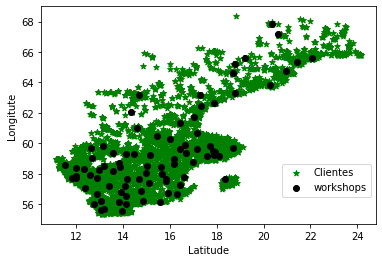

In [13]:
#Código para graficar
plt.scatter(datosClientes['longitude'],datosClientes['latitude'], marker="*", color="green", label="Clientes") 
plt.scatter(datos['longitude'],datos['latitude'], c='black', label="workshops")


plt.ylabel("Longitute")
plt.xlabel("Latitude")
plt.legend(bbox_to_anchor=(1, 0.3))
plt.show()

Ahora podemos ver la dispersion de los talleres que solo arreglan camiones vs los que arreglan ambos

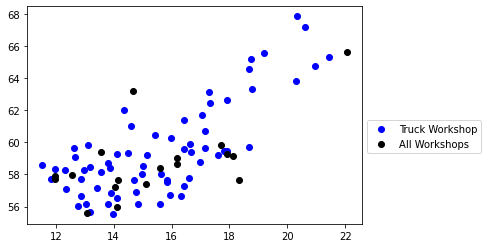

In [18]:
all_workshop = Global_workshops[Global_workshops['servicebus'] == 1] 
truck_workshop = Global_workshops[Global_workshops['servicebus'] == 0] 

plt.scatter(truck_workshop['longitude'],truck_workshop['latitude'], c='blue', label="Truck Workshop")
plt.scatter(all_workshop['longitude'],all_workshop['latitude'], c='black', label="All Workshops")
plt.legend(bbox_to_anchor=(1, 0.5))
plt.show()

### Entrenamos el modelo

In [20]:
clasificador = KNeighborsClassifier(n_neighbors=1)

clasificador.fit(datos, clase)

KNeighborsClassifier(n_neighbors=1)

### Realizamos predicciones de prueba

In [21]:
print("Workshop:", clasificador.predict(datosClientesBus[datosClientesBus['servicebus'] == 1]))
#print("Workshop:", clasificador.predict(datosClientesBus_minmax))
#print("Workshop:", clasificador.predict(datosClientes_minmax))

Workshop: [40457 40846 40846 40784 40487 40620 40267 40650 40015 40457 40484 40360
 40784 40650 40015 40340 40457 40595 40230 40210 40210 40487 40487 40360
 40457 40410 40287 40340 40623 40680 40846 40288 40680 40483 40595 40599
 40067 40770 40435 40015 40466 40487 40267 40814 40410 40846 40360 40015
 40360 40457 40210 40210 40650 40585 40287 40287 40210 40680 40457 40067
 40487 40286 40287 40554 40846 40266 40650 40487 40680 40410 40784 40360
 40210 40680 40410 40680 40435 40457 40680 40487 40210 40846 40457 40585
 40487 40210 40585 40457 40210 40680 40595 40585 40554 40770 40340 40680
 40680 40487 40487 40015 40680 40286 40585 40554 40340 40340 40210 40680
 40680 40435 40015 40585 40340 40360 40435 40770 40457 40784 40585 40435
 40435 40340 40340 40680 40585 40680 40015 40585 40680 40680 40554 40680
 40210 40278 40823 40585 40680 40680 40278 40784 40595 40680 40585 40680
 40680 40286 40410 40620 40279 40585 40210 40340 40680 40554 40784 40435
 40015 40585 40585 40585 40770 40487 4068